In [ ]:
#Needed installs to SageMaker

#!pip install tensorflow==1.15.0
#!pip install tensorflow==2.1.0
#!pip install --upgrade tensorflow
#!pip install tensorflow --upgrade
#!conda install -y s3fs
#!pip install -U keras-tuner
#!pip install Keras
#!pip install --upgrade pip 
#!pip install tensorflow_gpu

In [155]:
#Imports 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import glob
from PIL import Image
%matplotlib inline 

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from skimage import io, color, filters
from skimage.transform import resize, rotate
from skimage.color import rgb2gray

#TensorFlow Imports
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import (Dense, Dropout, Activation,
                                     Flatten, Conv2D, MaxPooling2D,
                                    AveragePooling2D, Input)

#from kerastuner.tuners import RandomSearch, Hyperband
from kerastuner.engine.hypermodel import HyperModel
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import to_categorical
import tensorflow as tf


#AWS Imports
import s3fs
import sagemaker
from sagemaker import get_execution_role

# Database #1 - Combine data from images and labeled text files

In [47]:
#Initialize variable to reference S3
fs = s3fs.S3FileSystem()

#Read text files in S3 bucket using s3fs. Source: (https://talhassner.github.io/home/projects/Adience/Adience-data.html)
fs.ls('s3://louisbove01/Text_File/')

['louisbove01/Text_File/aligned',
 'louisbove01/Text_File/fold_0_data.txt',
 'louisbove01/Text_File/fold_1_data.txt',
 'louisbove01/Text_File/fold_2_data.txt',
 'louisbove01/Text_File/fold_3_data.txt',
 'louisbove01/Text_File/fold_4_data.txt']

In [48]:
#Load text files into Pandas DataFrame in order to match pictures
txt_file_lst = []
for i in range(5):
    txt_df = pd.read_csv(fs.open("s3://louisbove01/Text_File/fold_" + str(i) + "_data.txt"), sep='\t')
    txt_file_lst.append(txt_df)

#Clean the data
txt_index = pd.DataFrame()
txt_index = pd.concat(txt_file_lst)
txt_index_clean = txt_index.dropna().iloc[:,[1,3]]

#Show the first 5 rows of the txt DataFrame to merge with Images Dataframe
txt_index_clean.head()

,original_image,age
0,10399646885_67c7d20df9_o.jpg,"(25, 32)"
1,10424815813_e94629b1ec_o.jpg,"(25, 32)"
2,10437979845_5985be4b26_o.jpg,"(25, 32)"
3,10437979845_5985be4b26_o.jpg,"(25, 32)"
4,11816644924_075c3d8d59_o.jpg,"(25, 32)"


In [49]:
#Create list containing the names of all the image files in the sub-folders. Source: (https://talhassner.github.io/home/projects/Adience/Adience-data.html)
img_lst = []
for i in fs.ls('s3://louisbove01/Text_File/aligned/'):
    for j in fs.ls('s3://'+str(i)):
        img_lst.append(j)

In [50]:
#Choose pixels
pix = 100

#Load images into Pandas DataFrame
cv_img = {}
for img in img_lst:
    with fs.open(img) as f:
        im = Image.open(f) #Image open variable
        im = im.convert('L') #Convert image to grayscale
        gray_img = np.asarray(im) #Change to array
        resize_img = cv2.resize(gray_img,(pix,pix)) #Reduce the photo quality to avoid overfitting
        cv_img[img.split('.')[-2]+'.'+img.split('.')[-1]] = resize_img #Add image to dictionary and modify name to match text files

In [51]:
#Convert dictionary to DataFrame
cv_img_df = pd.DataFrame(cv_img.items(),columns=['name','image'])

#Show the txt DataFrame to merge with the text Dataframe
cv_img_df.head()

,name,image
0,9523333835_c7887c3fde_o.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 16, ..."
1,9524511337_2d3c153c15_o.jpg,"[[91, 85, 93, 97, 113, 67, 99, 60, 141, 107, 7..."
2,9526641039_f72415beb0_o.jpg,"[[66, 29, 25, 27, 29, 23, 23, 26, 29, 29, 28, ..."
3,9526735102_da50b50398_o.jpg,"[[170, 171, 170, 172, 173, 184, 185, 182, 182,..."
4,9529380116_084ce5f5f1_o.jpg,"[[91, 85, 93, 97, 113, 67, 99, 60, 141, 107, 7..."


In [52]:
cv_img_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13082 entries, 0 to 13081
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    13082 non-null  object
 1   image   13082 non-null  object
dtypes: object(2)
memory usage: 204.5+ KB


### Combine images and text labels

In [53]:
#Merge the text Dataframe and image Dataframe 
db1 = txt_index_clean.merge(cv_img_df, left_on='original_image', right_on='name')

#Get rid of unnessessary columns
db1 = db1.iloc[:,[1,3]] 

#Remove non-standard rows that fall outside the age ranges (0-2, 4-6, 8-13, 15-20, 25-32, 38-43, 48-53, 60-)
counts = db1['age'].value_counts()
db1['age'] = db1[~db1['age'].isin(counts[counts < 500].index)]
db1.dropna(inplace=True)

#Clean the filenames so we have Age, First Age in the Age Range and the Image column
db1['age_'] = db1['age'].str.split(',',1).apply(lambda x: x[0])
db1['age_rng_str'] = db1['age_'].str.strip('(')
db1 = db1.iloc[:,[3,0,1]].dropna()

#Remove the 'None' and 'NaN' values
db1['age_rng_str'] = pd.to_numeric(db1['age_rng_str'], errors='coerce') #Replace non-numeric values 
db1['age_rng_str'] = db1['age_rng_str'].dropna().astype(int) #Drop NaN values and convert to int values

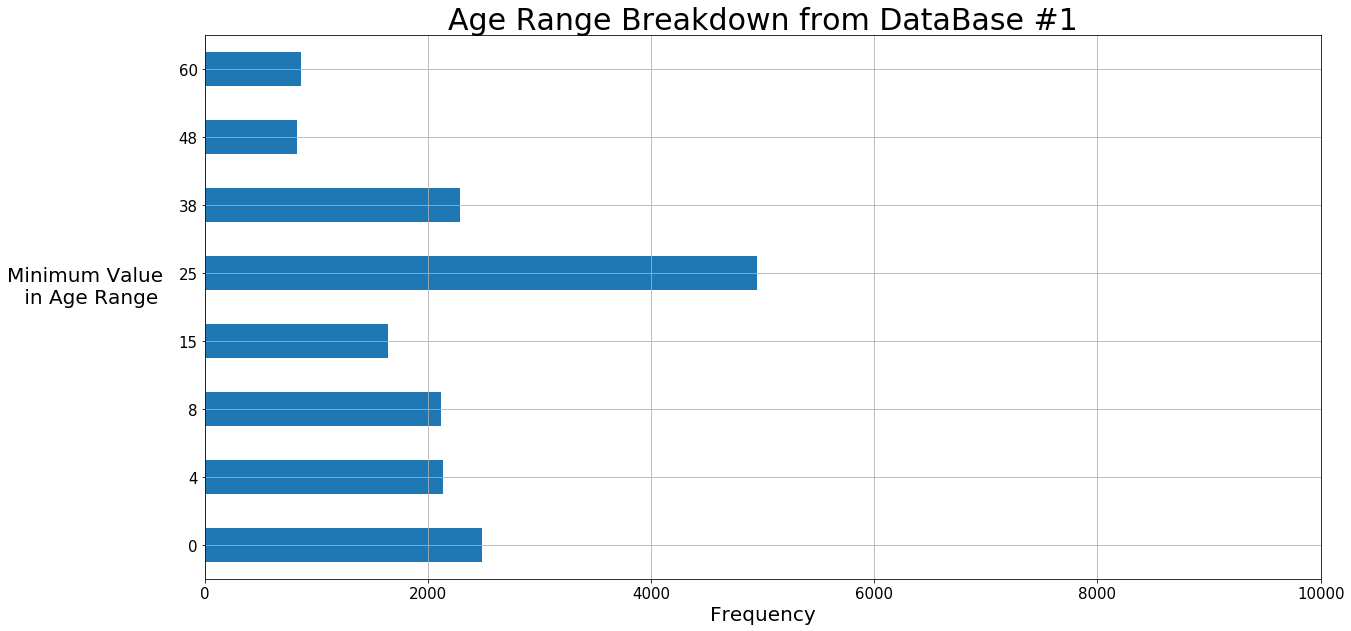

In [54]:
# Plot the age breakdown in a histogram
db1.groupby('age_rng_str').size().plot(kind='barh',figsize=(20,10),
                  grid=True,legend=False, fontsize=15)
plt.title('Age Range Breakdown from DataBase #1', fontdict = {'fontsize' : 30})
plt.xlabel('Frequency', fontdict = {'fontsize' : 20})
plt.ylabel('Minimum Value \n in Age Range', fontdict = {'fontsize' : 20},rotation=0,labelpad=90)
plt.xlim(0,10000)
plt.show()

In [55]:
#Show DataFrame info 
db1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17327 entries, 0 to 18590
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age_rng_str  17327 non-null  int64 
 1   age          17327 non-null  object
 2   image        17327 non-null  object
dtypes: int64(1), object(2)
memory usage: 541.5+ KB


# Database #2 - Labeled images

In [56]:
#Create list of all images files in folder. Source: (https://susanqq.github.io/UTKFace/)
img_lst2 = []
for i in fs.ls('s3://louisbove01/Title_UTKFace/'):
    for j in fs.ls('s3://'+str(i)):
        img_lst2.append(j)

In [57]:
#Load images into a dictionary
cv_img2 = {}
for img in img_lst2:
    with fs.open(img) as f:
        im = Image.open(f)
        im = im.convert('L') #Convert image to grayscale
        gray_img = np.asarray(im) #Change to array
        resize_img = cv2.resize(gray_img,(pix,pix)) #Reduce the photo quality to avoid overfitting
        cv_img2[img] = resize_img#.reshape(-1) #Add image to dictionary and modify name to match text files

#Convert dictionary to DataFrame
cv_img_df2 = pd.DataFrame(cv_img2.items(),columns=['filename','image'])

#Convert the 'filename' column to an age column
cv_img_df2['filename_split'] = cv_img_df2['filename'].str.split('_',2).apply(lambda x: x[1])
cv_img_df2['age'] = cv_img_df2['filename_split'].str.split('/').apply(lambda x: x[1]).astype(int)

#Show the DataFrame
db2 = cv_img_df2.iloc[:,[3,1]]
#db2.value_counts()

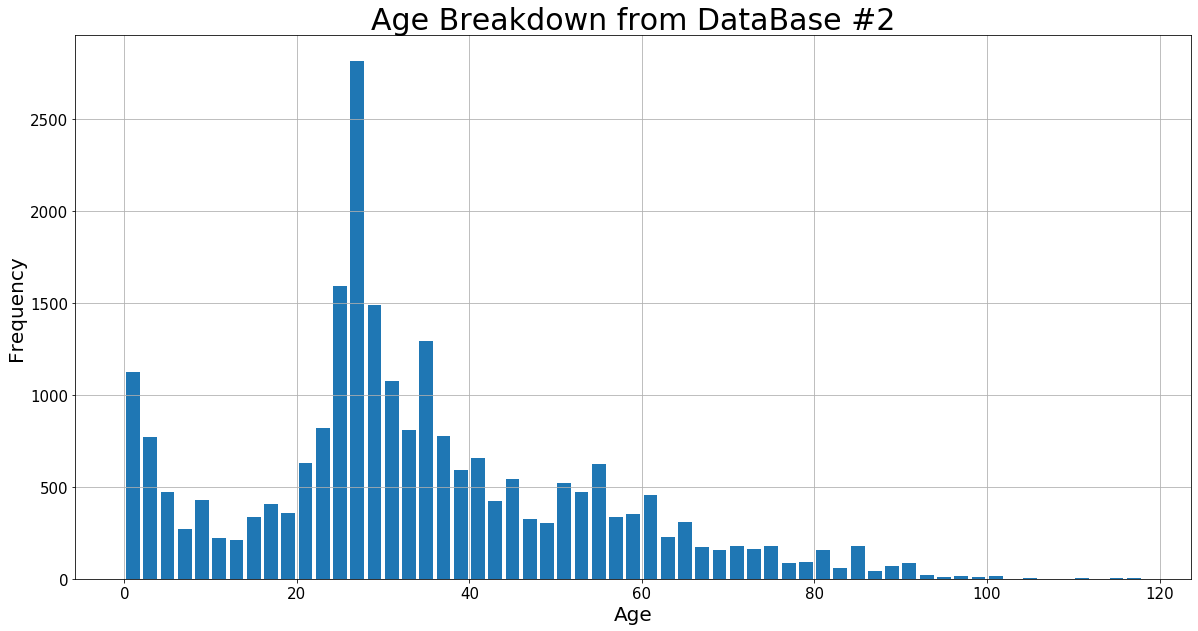

In [58]:
# Plot the age breakdown in a histogram
db2[['age']].plot(kind='hist',bins=list(range(0,120,2)),rwidth=0.8,figsize=(20,10),
                  grid=True,legend=False, fontsize=15)
plt.title('Age Breakdown from DataBase #2', fontdict = {'fontsize' : 30})
plt.xlabel('Age', fontdict = {'fontsize' : 20})
plt.ylabel('Frequency', fontdict = {'fontsize' : 20})
plt.show()

In [59]:
#Break DataBase into age ranges: (0-2, 4-6, 8-13, 15-20, 25-32, 38-43, 48-53, 60-)
bins = [0, 3, 7, 14, 24, 37, 47, 60, np.inf]
names = ['0-3', '4-7', '8-14', '15-24', '25-37', '38-47', '48-59', '60+']
db2['age_rng'] = pd.cut(db2['age'], bins, labels=names)

#Break DataBase into minimum age for each age range
bins = [0, 3, 7, 14, 24, 37, 47, 60, np.inf]
ages = [0, 4, 8, 15, 25, 38, 48, 60]
db2['age_rng_str'] = pd.cut(db2['age'], bins, labels=ages)

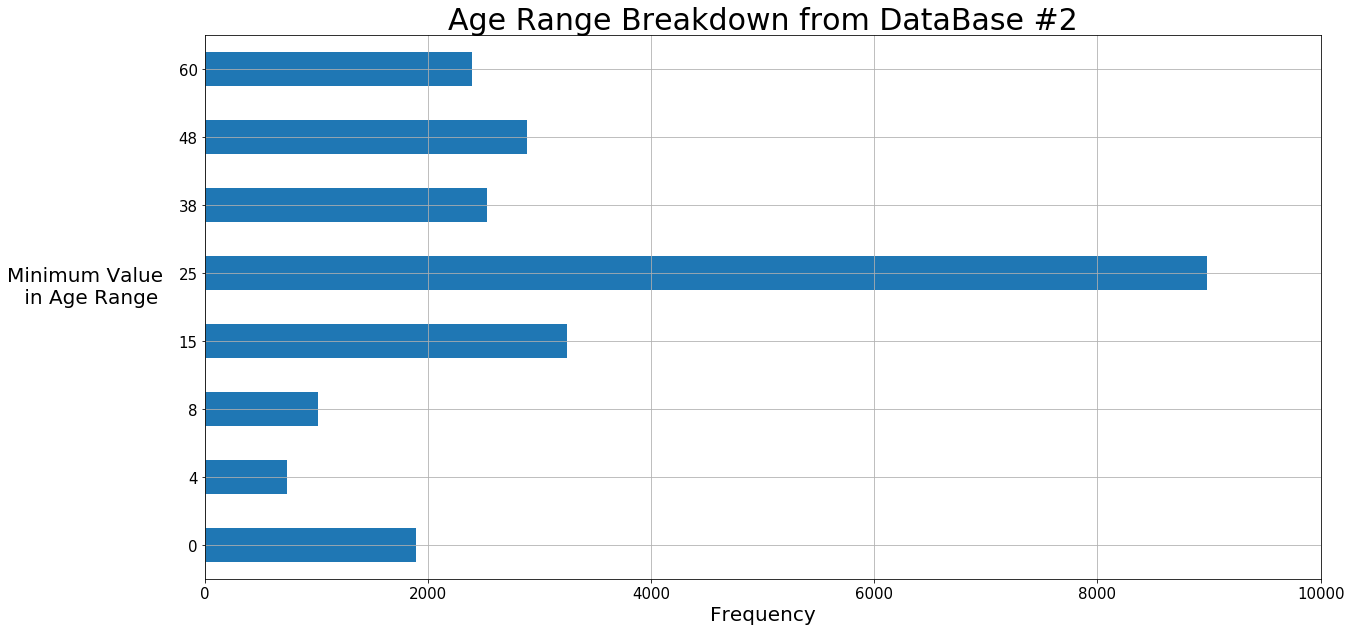

In [60]:
# Plot the age breakdown in a histogram
db2.groupby('age_rng_str').size().plot(kind='barh',figsize=(20,10),
                  grid=True,legend=False, fontsize=15)
plt.title('Age Range Breakdown from DataBase #2', fontdict = {'fontsize' : 30})
plt.xlabel('Frequency', fontdict = {'fontsize' : 20})
plt.ylabel('Minimum Value \n in Age Range', fontdict = {'fontsize' : 20},rotation=0,labelpad=90)
plt.xlim(0,10000)
plt.show()

In [61]:
#Show DataFrame info
db2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   age          23708 non-null  int64   
 1   image        23708 non-null  object  
 2   age_rng      23708 non-null  category
 3   age_rng_str  23708 non-null  category
dtypes: category(2), int64(1), object(1)
memory usage: 417.6+ KB


# Database #3 - Labeled folders

In [62]:
#Create list of all image files in folder. Source: (https://www.kaggle.com/frabbisw/facial-age)
img_lst3 = []
for i in fs.ls('s3://louisbove01/Folder_face_age/'):
    for j in fs.ls('s3://'+str(i)):
        img_lst3.append(j)

#Load images into a dictionary
cv_img3 = {}
for img in img_lst3:
    with fs.open(img) as f:
        im = Image.open(f)
        im = im.convert('L') #Convert image to grayscale
        gray_img = np.asarray(im) #Change to array
        resize_img = cv2.resize(gray_img,(pix,pix)) #Reduce the photo quality to avoid overfitting
        cv_img3[img] = resize_img#.reshape(-1) #Add image to dictionary and modify name to match text files

#Convert dictionary to DataFrame
cv_img_df3 = pd.DataFrame(cv_img3.items(),columns=['filename','image'])

#Convert the 'filename' column to an age column
cv_img_df3['age'] = cv_img_df3['filename'].str.split('/').apply(lambda x: x[-2]).astype(int)

#Show the DataFrame
db3 = cv_img_df3.iloc[:,[2,1]]

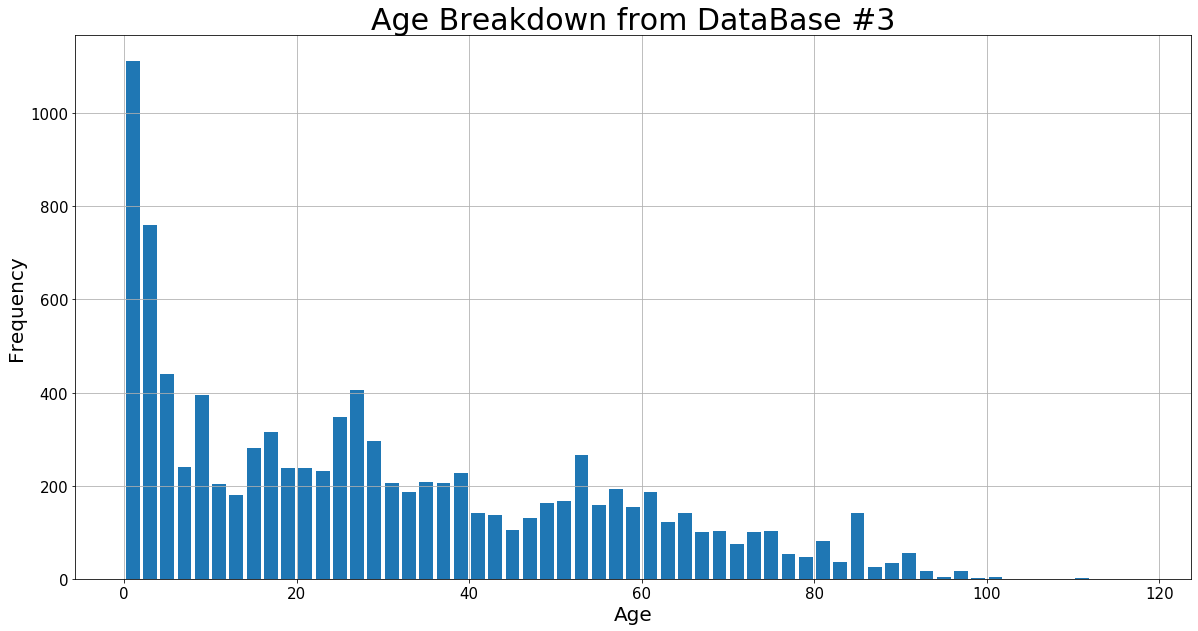

In [63]:
# Plot the age breakdown in a histogram
db3[['age']].plot(kind='hist',bins=list(range(0,120,2)),rwidth=0.8,figsize=(20,10),
                  grid=True,legend=False, fontsize=15)
plt.title('Age Breakdown from DataBase #3', fontdict = {'fontsize' : 30})
plt.xlabel('Age', fontdict = {'fontsize' : 20})
plt.ylabel('Frequency', fontdict = {'fontsize' : 20})
plt.show()

In [64]:
#Break DataBase into age ranges: (0-2, 4-6, 8-13, 15-20, 25-32, 38-43, 48-53, 60-)
bins = [0, 3, 7, 14, 24, 37, 47, 60, np.inf]
names = ['0-3', '4-7', '8-14', '15-24', '25-37', '38-47', '48-59', '60+']
db3['age_rng'] = pd.cut(db3['age'], bins, labels=names)

#Break DataBase into minimum age for each age range
bins = [0, 3, 7, 14, 24, 37, 47, 60, np.inf]
ages = [0, 4, 8, 15, 25, 38, 48, 60]
db3['age_rng_str'] = pd.cut(db3['age'], bins, labels=ages)

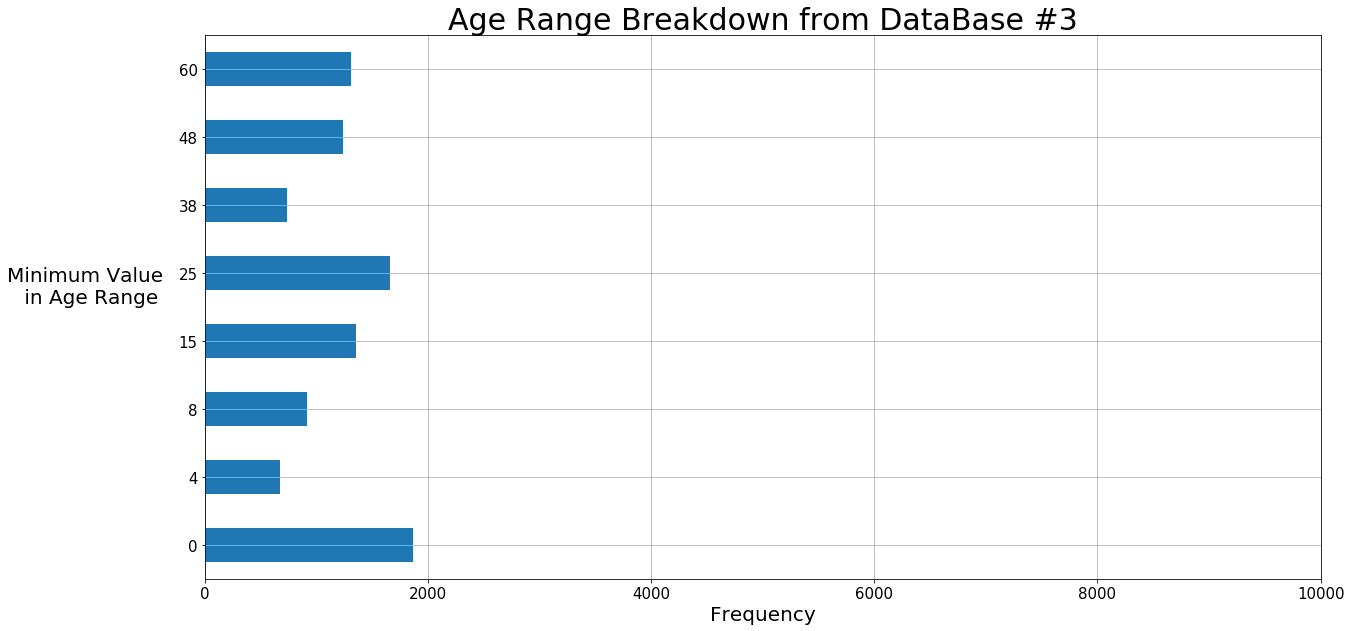

In [65]:
# Plot the age breakdown in a histogram
db3.groupby('age_rng_str').size().plot(kind='barh',figsize=(20,10),
                  grid=True,legend=False, fontsize=15)
plt.title('Age Range Breakdown from DataBase #3', fontdict = {'fontsize' : 30})
plt.xlabel('Frequency', fontdict = {'fontsize' : 20})
plt.ylabel('Minimum Value \n in Age Range', fontdict = {'fontsize' : 20},rotation=0,labelpad=90)
plt.xlim(0,10000)
plt.show()

In [66]:
#Summary of the data
db3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9778 entries, 0 to 9777
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   age          9778 non-null   int64   
 1   image        9778 non-null   object  
 2   age_rng      9778 non-null   category
 3   age_rng_str  9778 non-null   category
dtypes: category(2), int64(1), object(1)
memory usage: 172.8+ KB


# Combined Data Set

In [67]:
#Concatenate the three data frames into one
frames = [db1[['image','age_rng_str']],db2[['image','age_rng_str']],db3[['image','age_rng_str']]]
df_combined = pd.concat(frames)

In [68]:
#Summary of the data
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50813 entries, 0 to 9777
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image        50813 non-null  object
 1   age_rng_str  50813 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


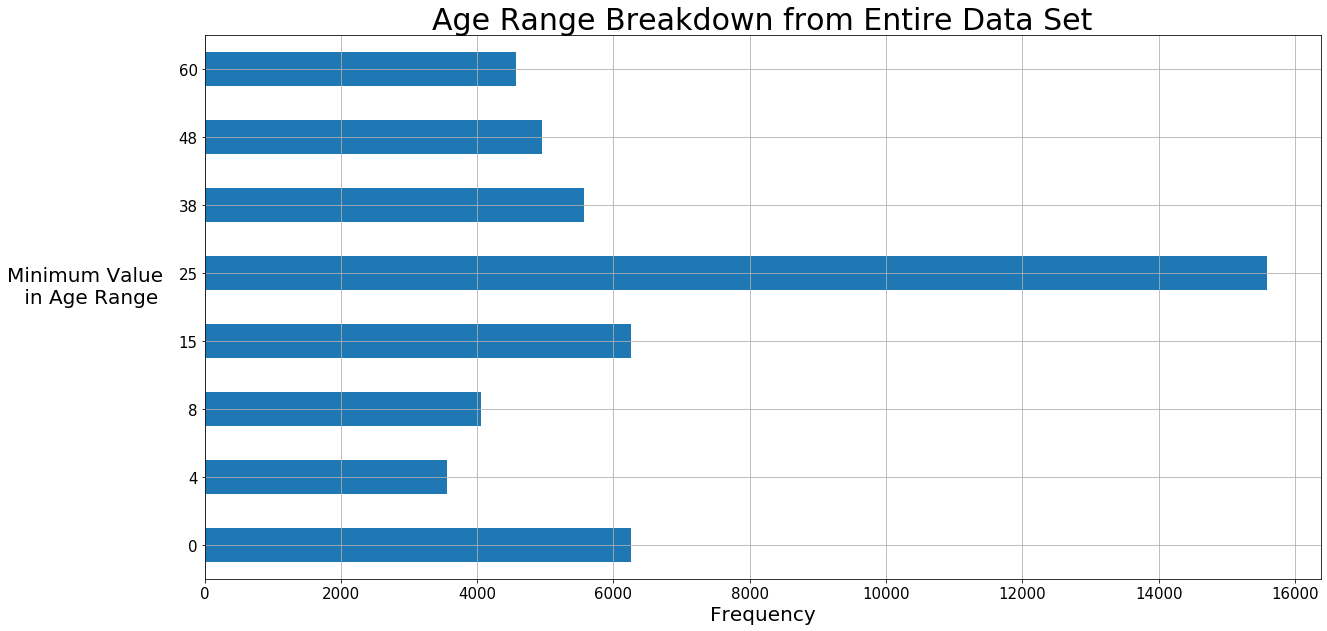

In [69]:
# Plot the age breakdown in a histogram
df_combined.groupby('age_rng_str').size().plot(kind='barh',figsize=(20,10),
                  grid=True,legend=False, fontsize=15)
plt.title('Age Range Breakdown from Entire Data Set', fontdict = {'fontsize' : 30})
plt.xlabel('Frequency', fontdict = {'fontsize' : 20})
plt.ylabel('Minimum Value \n in Age Range', fontdict = {'fontsize' : 20},rotation=0,labelpad=90)
plt.show()

In [70]:
#Drop half the data from the 25-37 age range
df_combined.drop(df_combined[df_combined['age_rng_str']==25].iloc[0:8000].index, inplace=True)

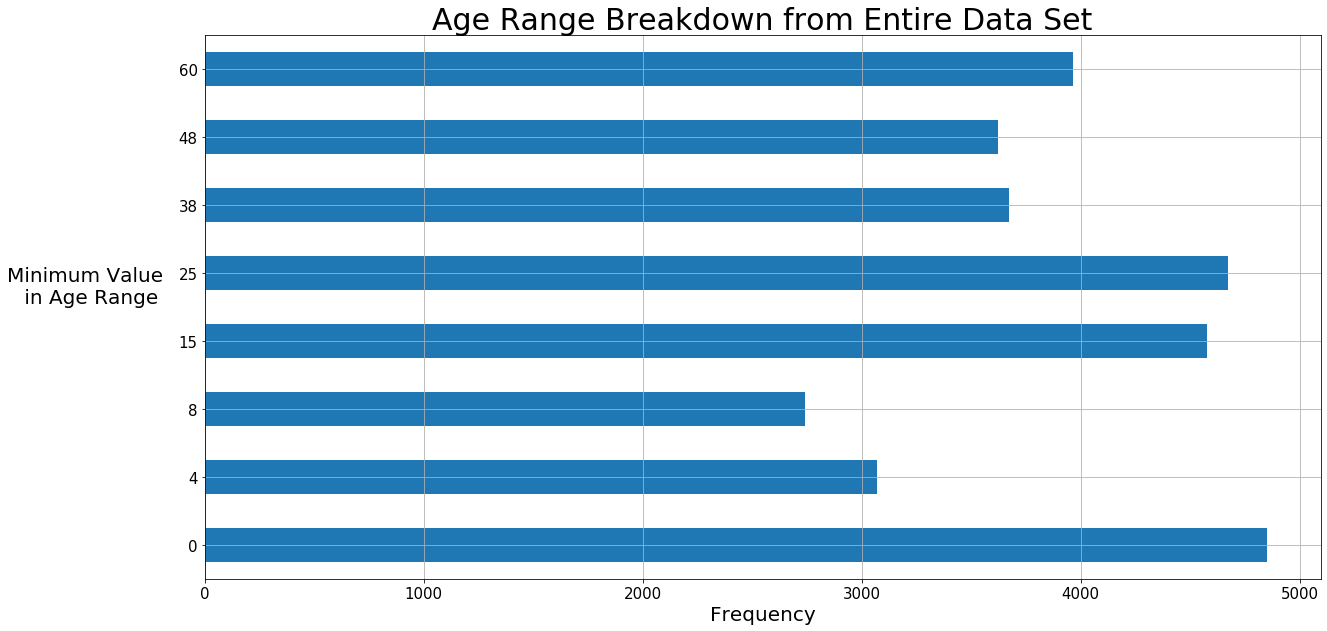

In [71]:
# Plot the age breakdown in a histogram
df_combined.groupby('age_rng_str').size().plot(kind='barh',figsize=(20,10),
                  grid=True,legend=False, fontsize=15)
plt.title('Age Range Breakdown from Entire Data Set', fontdict = {'fontsize' : 30})
plt.xlabel('Frequency', fontdict = {'fontsize' : 20})
plt.ylabel('Minimum Value \n in Age Range', fontdict = {'fontsize' : 20},rotation=0,labelpad=90)
plt.show()

In [72]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31173 entries, 6 to 9777
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image        31173 non-null  object
 1   age_rng_str  31173 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 730.6+ KB


In [ ]:
#Save dataframe to a pickle file 
df_combined.to_pickle("df.pkl100")

# CNN Base Model

In [182]:
#Read in pickle file with data
df = pd.read_pickle("df.pkl100")
df.shape

(31173, 2)

In [184]:
#Train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['image'].array, df['age_rng_str'].array, random_state=1)

#Normalize the data (scaling from 0 to 1)
X_train /= 255
X_test /= 255

#Reshape the image column in the X_train and X_test set in preparation for the CNN model
lst1 = []
for i in X_train:
    lst1.append(np.reshape(i,(100,100,1)))

lst1 = np.array(lst1)    
X_train = lst1
X_train.shape

#Reshape X_test
lst2 = []
for i in X_test:
    lst2.append(np.reshape(i,(100,100,1)))

lst2 = np.array(lst2)    
X_test = lst2
X_test.shape

#One Hot Encode the target data for the CNN Model to pandas DataFrame
y_train_pd = pd.get_dummies(y_train)
y_test_pd = pd.get_dummies(y_test)

#One Hot Encode the target data for the CNN Model to numpy array
y_train = pd.get_dummies(y_train).to_numpy()
y_test = pd.get_dummies(y_test).to_numpy()

In [143]:
#Deploy CNN Model using the training and testing data
model = Sequential([
      
    #Convolutional Layer (extracts features from a source image)
    Conv2D(32, 3, activation='relu', input_shape=(100, 100, 1), padding = "same"),
       
    #Convolutional Layer (extracts features from a source image)
    Conv2D(32, 3, activation="relu"),
    
    #Max Pooling (retains the most prominent features of the feature map) 
    MaxPooling2D(2,2),
    
    #Convolutional Layer 
    Conv2D(128, 3, activation="relu"),
    
    #Convolutional Layer 
    Conv2D(128, 3, activation="relu"),
    
    #Max Pooling (retains the most prominent features of the feature map)
    MaxPooling2D(2,2),
    
    #Flatten
    Flatten(),
    
    #Pass through the hidden layers
    Dense(64, activation='relu'),
    
    #Dropout 50% of layer connections at random (use for overfitting)
    Dropout(0.5),
    
    #Pass through the hidden layers
    Dense(8, activation='softmax')
])

In [144]:
#Get a summary of the CNN Model results
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 100, 100, 32)      320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 98, 98, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 47, 47, 128)       36992     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 45, 45, 128)       147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 61952)            

In [ ]:
#Compile the model
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

# during fit process watch train and test error simultaneously
model.fit(X_train, y_train, batch_size=32, epochs=40,
        verbose=1, validation_data=(X_test, y_test))

#Determine the model scores and print them out
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1]) # this is the one we care about

Train on 23379 samples, validate on 7794 samples
Epoch 1/40
23379/23379 [==============================] - 600s 26ms/sample - loss: 0.8163 - accuracy: 0.6527 - val_loss: 1.3630 - val_accuracy: 0.6133
Epoch 2/40
23379/23379 [==============================] - 600s 26ms/sample - loss: 0.8073 - accuracy: 0.6576 - val_loss: 1.2994 - val_accuracy: 0.6116
Epoch 3/40
23379/23379 [==============================] - 602s 26ms/sample - loss: 0.7904 - accuracy: 0.6632 - val_loss: 1.3955 - val_accuracy: 0.6171
Epoch 4/40
23379/23379 [==============================] - 600s 26ms/sample - loss: 0.7968 - accuracy: 0.6570 - val_loss: 1.4042 - val_accuracy: 0.6134
Epoch 5/40
23379/23379 [==============================] - 601s 26ms/sample - loss: 0.7871 - accuracy: 0.6644 - val_loss: 1.3328 - val_accuracy: 0.6186
Epoch 6/40
23379/23379 [==============================] - 602s 26ms/sample - loss: 0.7934 - accuracy: 0.6648 - val_loss: 1.3650 - val_accuracy: 0.6096
Epoch 7/40
23379/23379 [=====================

In [ ]:
#Save the model
model.save('base_model2.h5')

In [ ]:
#Create a confusion matrix heatmap using MatPlotLib
def create_cm_heat_map(ml_model, X, y_labelled):
    
    #Create a variable for the predicted results of X_test based on the model
    predictions = ml_model.predict_classes(X, batch_size=32, verbose=0)

    #Change the predicted results from column number to the first age of the age range to compare with y_test
    val_dict = {0:0, 1:4, 2:8, 3:15, 4:25, 5:38, 6:48, 7:60}
    holder = []
    for i in predictions:
        holder.append(val_dict[i])

    #Reassign to predictions variable
    rounded_predictions = np.array(holder)

    #Create a variable for the y_test results
    rounded_labels = np.array(y_labelled.idxmax(axis=1))

    #Create a confusion matrix of the initial results
    cm = confusion_matrix(rounded_labels, rounded_predictions)
    matrix = np.round_(cm/np.sum(cm),2)
    
    fig, ax = plt.subplots(figsize=(9,9))
    im = ax.imshow(matrix)

    #Age Range Labels
    age_rng = ['0-3', '4-7', '8-14', '15-24', '25-37', '38-47', '48-59', '60+']

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(age_rng)))
    ax.set_yticks(np.arange(len(age_rng)))

    # ... and label them with the respective list entries
    ax.set_xticklabels(age_rng)
    ax.set_yticklabels(age_rng)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(age_rng)):
        for j in range(len(age_rng)):
            text = ax.text(j, i, matrix[i, j],
                           ha="center", va="center", color="black")

    #Label the axis and show the results
    ax.set_title("Predicted Age Range vs. Actual Age Range", fontdict = {'fontsize' : 30})
    ax.set_xlabel("Predicted", fontdict = {'fontsize' : 20},labelpad=15)
    ax.set_ylabel("Actual", fontdict = {'fontsize' : 20},rotation=0,labelpad=40)
    fig.tight_layout()
    
    #fig.colorbar('Blues')
    plt.set_cmap('Blues')
    plt.show()
    pass

In [ ]:
#Create Model accuracy function
def mod_acc(model):
    plt.plot(model.history.history['accuracy'])
    plt.plot(model.history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    pass

In [ ]:
#Create Model loss function
def mod_loss(model):
    plt.plot(model.history.history['loss'])
    plt.plot(model.history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    pass

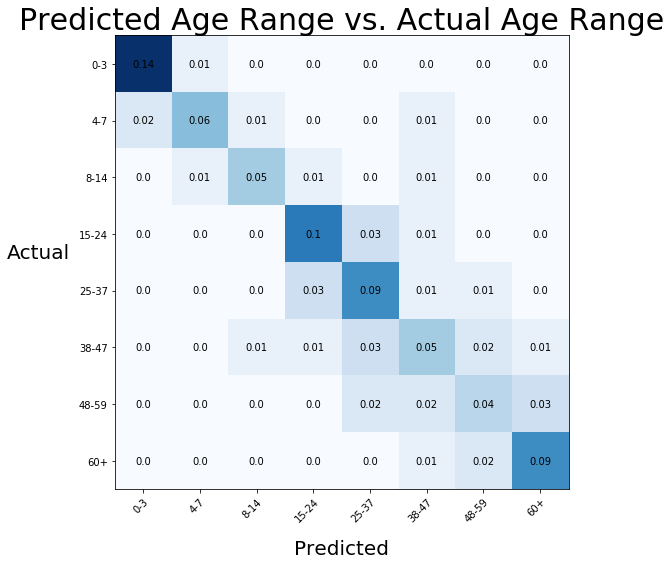

In [ ]:
#Confusion Matrix
create_cm_heat_map(model, X_test, y_test_pd)

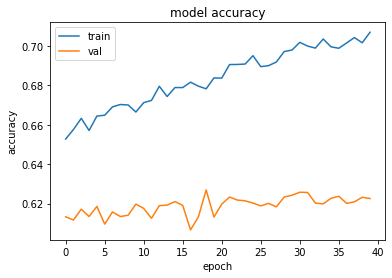

In [ ]:
#Model accuracy score of test vs. validation 
mod_acc(model)

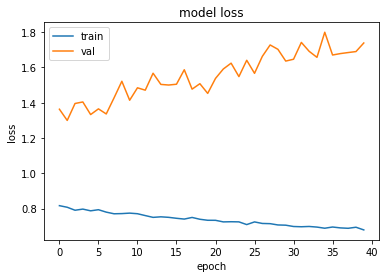

In [ ]:
#Model loss score of test vs. validation 
mod_loss(model)

# Base Model Tuning

In [134]:
#Tuner model function
def build_model():
    
    model = Sequential()
      
    #Convolutional Layer (extracts features from a source image)
    model.add(Conv2D(32, 3, activation='relu', input_shape=(100, 100, 1), padding = "same"))
    model.add(Conv2D(64, 3, activation="relu")) #hp.Choice("Conv2", [32,64,128,256])
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(128, 3, activation="relu")) #hp.Choice("Conv2", [32,64,128,256])
    model.add(Conv2D(256, 3, activation="relu")) #hp.Choice("Conv2", [32,64,128,256])
    model.add(MaxPooling2D(2,2)) 
    model.add(Flatten())
    model.add(Dense(2048, activation='relu')) #hp.Choice("Dense", [8,16,32,64,128,256,512,1024,2048])
    model.add(Dropout(0.2))  #hp.Choice("Dropout", [0.2,0.4,0.5,0.6,0.8])
    model.add(Dense(8, activation='softmax'))

    model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
#tuner = RandomSearch(build_model, objective='val_accuracy', max_trials = 1)

In [ ]:
#tuner.search(X_train, y_train, validation_data = (X_test, y_test), epochs = 2, batch_size = 32)

In [ ]:
#Take the best model from the tuner
best_model = tuner.get_best_models()[0]

#Get a summary of the best model
best_model.summary()

In [210]:
#Deploy CNN Model using the training and testing data
best_model = Sequential([
      
    #Convolutional Layer (extracts features from a source image)
    Conv2D(32, 3, activation='relu', input_shape=(100, 100, 1), padding = "same"),
       
    #Convolutional Layer (extracts features from a source image)
    Conv2D(64, 3, activation="relu"),
    
    #Max Pooling (retains the most prominent features of the feature map) 
    MaxPooling2D(3,3),
    
    #Dropout 50% of layer connections at random (use for overfitting)
    Dropout(0.2),
    
    #Convolutional Layer 
    Conv2D(128, 3, activation="relu"),
    
    #Convolutional Layer 
    #Conv2D(256, 3, activation="relu"),
    
    #Max Pooling (retains the most prominent features of the feature map)
    MaxPooling2D(3,3),
    
    #Dropout 50% of layer connections at random (use for overfitting)
    Dropout(0.2),
    
    #Flatten
    Flatten(),
    
    #Pass through the hidden layers
    Dense(2048, activation='relu'),
    
    #Dropout 50% of layer connections at random (use for overfitting)
    Dropout(0.2),
    
    #Pass through the hidden layers
    Dense(8, activation='softmax')
])

In [193]:
#Compile the model
best_model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

# during fit process watch train and test error simultaneously
best_model.fit(X_train, y_train, batch_size=32, epochs=30,
        verbose=1, validation_data=(X_test, y_test))

#Determine the model scores and print them out
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1]) # this is the one we care about

Train on 23379 samples, validate on 7794 samples
Epoch 1/30
23379/23379 [==============================] - 158s 7ms/sample - loss: 1.7042 - accuracy: 0.3434 - val_loss: 1.3912 - val_accuracy: 0.4450
Epoch 2/30
23379/23379 [==============================] - 158s 7ms/sample - loss: 1.3729 - accuracy: 0.4582 - val_loss: 1.2773 - val_accuracy: 0.5023
Epoch 3/30
23379/23379 [==============================] - 158s 7ms/sample - loss: 1.2482 - accuracy: 0.5064 - val_loss: 1.2000 - val_accuracy: 0.5354
Epoch 4/30
23379/23379 [==============================] - 158s 7ms/sample - loss: 1.1473 - accuracy: 0.5516 - val_loss: 1.1291 - val_accuracy: 0.5580
Epoch 5/30
23379/23379 [==============================] - 158s 7ms/sample - loss: 1.0557 - accuracy: 0.5871 - val_loss: 1.1084 - val_accuracy: 0.5675
Epoch 6/30
23379/23379 [==============================] - 158s 7ms/sample - loss: 0.9545 - accuracy: 0.6260 - val_loss: 1.1153 - val_accuracy: 0.5708
Epoch 7/30
23379/23379 [===========================

In [196]:
best_model.evaluate(X_test, y_test, verbose=0)

[1.642198507246495, 0.6134206]

In [197]:
#Save best model
best_model.save('best_model_after_tuning1.h5')

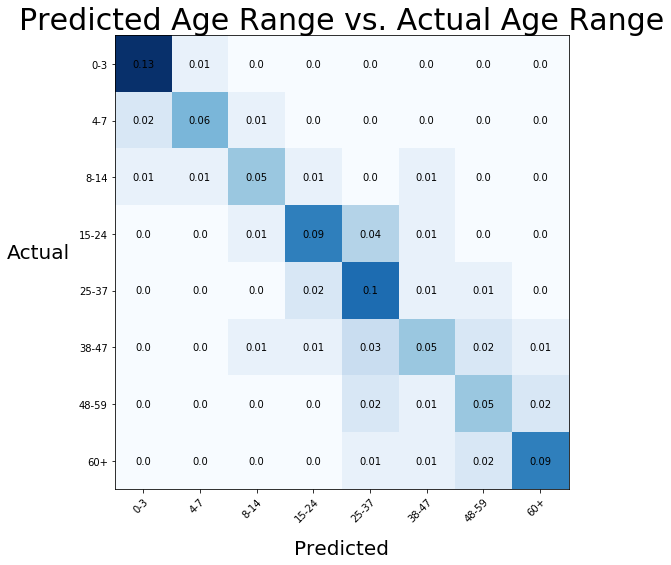

In [198]:
#Confusion Matrix
create_cm_heat_map(best_model, X_test, y_test_pd)

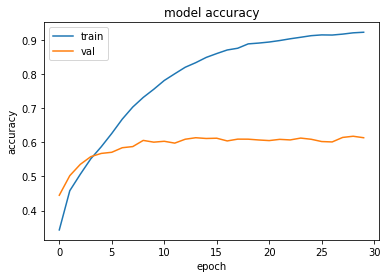

In [199]:
#Model accuracy score of test vs. validation 
mod_acc(best_model)

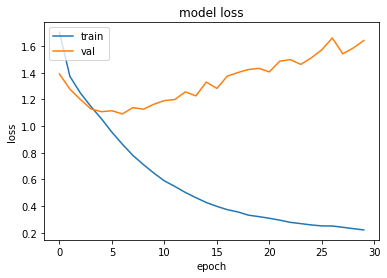

In [200]:
#Model loss score of test vs. validation 
mod_loss(best_model)

# Create Augmented Training Data 

#Tuned Model
aug_model = Sequential([
      
    #Convolutional Layer (extracts features from a source image)
    Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1), padding = "same"),
    
    #Max Pooling (retains the most prominent features of the feature map) 
    MaxPooling2D(2,2),
    
    #Dropout 50% of layer connections at random (use for overfitting)
    Dropout(0.2),     
    
    #Convolutional Layer (extracts features from a source image)
    Conv2D(128, (3,3), activation="relu"),
    #Conv2D(128, 3, activation="relu"),
    
    #Max Pooling (retains the most prominent features of the feature map)
    MaxPooling2D(2,2),
    
    #Dropout 50% of layer connections at random (use for overfitting)
    Dropout(0.2),
    
    #Flatten
    Flatten(),
    
    #Pass through the hidden layers
    Dense(2048, activation='relu'),
    
    #Dropout 50% of layer connections at random (use for overfitting)
    Dropout(0.2),
    
    #Pass through the hidden layers
    Dense(8, activation='softmax')
])

#Compile the model
aug_model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [213]:
#Outline the parameters of the augmentation filter
datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2)

#Create copy of the best model
aug_model = best_model

#Compile the model
aug_model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
aug_model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                        steps_per_epoch = X_train.shape[0] // 32,
                        epochs = 30,
                        validation_data = (X_test, y_test))

Epoch 1/30
730/730 [==============================] - 543s 744ms/step - loss: 1.8713 - accuracy: 0.2803 - val_loss: 1.5152 - val_accuracy: 0.4234
Epoch 2/30
668/730 [==========================>...] - ETA: 43s - loss: 1.5620 - accuracy: 0.3948

In [ ]:
#Determine the model scores and print them out
score = aug_model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1]) # this is the one we care about

In [204]:
#Save the model
aug_model.save('aug_model100.h5')

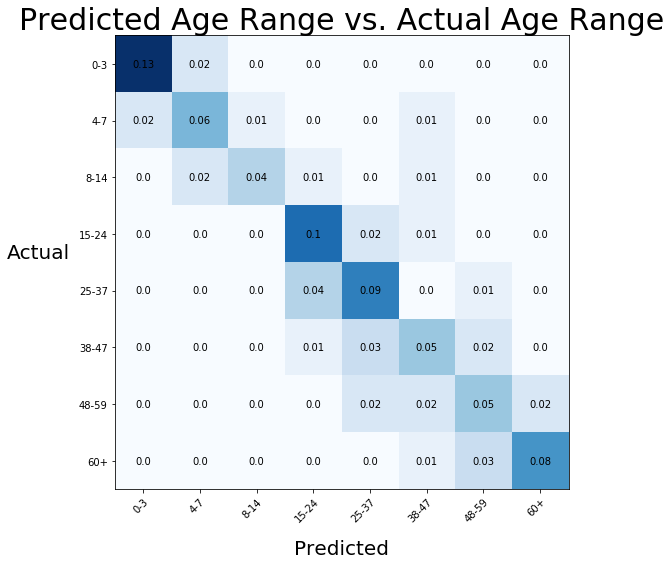

In [205]:
#Confusion Matrix
create_cm_heat_map(aug_model, X_test, y_test_pd)

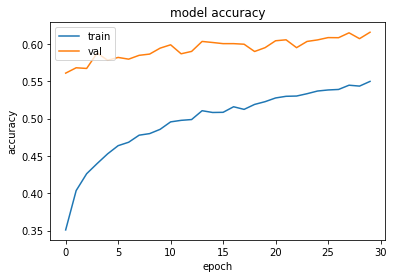

In [208]:
#Model accuracy score of test vs. validation 
mod_acc(aug_model)

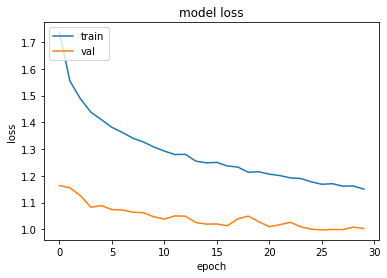

In [209]:
#Model loss score of test vs. validation 
mod_loss(aug_model)

# Further Exploration: Video Capture

import time

#Use built in camera to create videocamera object
video = cv2.VideoCapture(0)

#While loop variable
a = 1

#While loop to display and capture video images
while True:
    a += 1
    
    #check: bool type returning true if Python can read VideoCapture object
    #frame: object with first image captured 
    check, frame = video.read()

    #Print image 
    print(frame)
    
    #Convert the images to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    #Show the captured image
    cv2.imshow('Capture', gray)
    
    #Create variable for exiting while loop
    key = cv2.waitKey(1)
    
    if key == ord('q'):
        break

#Print number of frames
print(a)
        
#Release the camera 
video.release()

#Press any button to close the window
cv2.destroyAllWindows()